This notebook is intended to produce the vizualisations of Figure 5 from the paper. 

It deals with regularized optimal transport for Monge-Kantorovich quantiles in dimension `d=2`, and is intended to provide MK quantile contours as exact as possible for several values of the regularization parameter $\epsilon$, so that its influence can be understandable. 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
sns.set()

### Simulate banana-shaped data

[6.27594954e-05 3.33355314e-01]


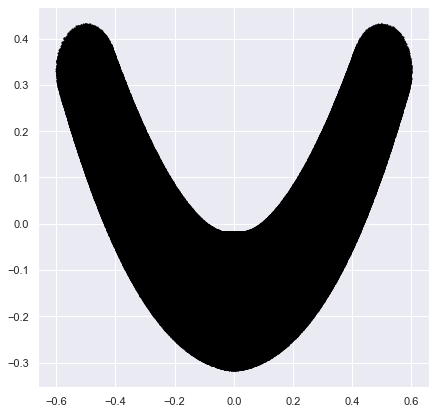

In [22]:
J = 10**7

d = 2 
X = -1 + 2 * np.random.random_sample((J,))
Phi = 2 * np.pi * np.random.random_sample((J,))
Z = np.random.random_sample((J,))
R = 0.2 * Z * (1+(1-abs(X))/2)
y1 = X + R * np.cos(Phi)
y2 = X**2 + R * np.sin(Phi)
Y = np.array([y1,y2])
Y = Y.T

# Center-reduce is necessary for computational reasons in EOT
scale = 2
print(np.mean(Y,axis=0))
Y = (Y-np.mean(Y,axis=0))/scale

plt.figure(figsize=(7,7))
plt.scatter(Y.T[0],Y.T[1],color="black",s=1)

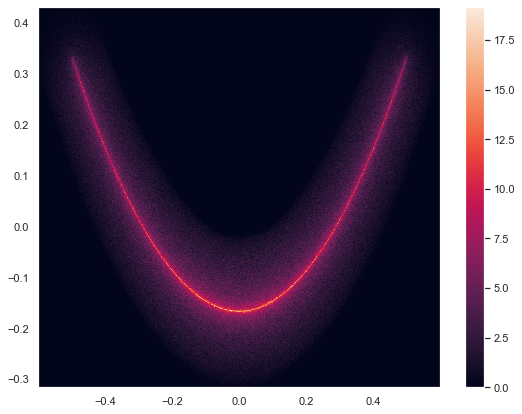

In [23]:
# Vizualise the density by heatmap
plt.figure(figsize=(9,7))
h = plt.hist2d(Y.T[0], Y.T[1],bins=1000,density=True)
plt.colorbar(h[3])

### Choice of a spherical grid

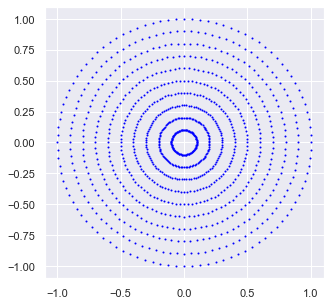

In [24]:
# Choix de la grille en coordonnées polaires
p1 = 10 # Nombre de rayons
p2 = 100 # Nombre d'angles

grid_r = np.mgrid[1:(p1+1), 1:(p2+1)][0]/p1
#print(grid_r)

grid_theta = (np.mgrid[1:(p1+1), 1:(p2+1)][1]/p2)*2*np.pi
#print(grid_theta)

# Visualisation des points en coordonnées cartésiennes
grid_x1 = grid_r*np.cos(grid_theta)
grid_x2 = grid_r*np.sin(grid_theta)
grid_x = np.array([grid_x1,grid_x2])

#print(grid_x1)
#print(grid_x2)
plt.figure(figsize=(5,5))
plt.scatter(grid_x1[:].reshape(p1*p2,1),grid_x2[:].reshape(p1*p2,1),color="blue",s=1)

### Functions for the FFT-based scheme 

In [25]:
def cost_fft2(grid_x,Y):
    diff1 = grid_x[0]-Y[0]
    diff2 = grid_x[1]-Y[1]
    return(0.5*(diff1**2 + diff2**2))

# Version FFT
def c_transform_fft2(u, grid_x, y, eps=0.1):
    """Calculate the c_transform of u"""
    arg = (u - cost_fft2(grid_x, y))/eps
    to_sum = np.exp(arg)
    return(-eps*np.log(np.mean(to_sum)))
    
def grad_heps_fft2(u, grid_x, y, eps=0.1):
    """
    Calculate the gradient h_eps 
    """

    F_u = np.exp((u - cost_fft2(grid_x, y))/eps)
    argD = np.mean(F_u)
    grad = -np.fft.fft2(F_u)/argD

    return(grad)

def h_eps_fft2(u, grid_x, y, eps=0.1):
    """
    Calculate the function h_eps whose expectation equals H_eps.
    """
    return(c_transform_fft2(u, grid_x, y, eps)-eps)

def Robbins_Monro_Algo_fft2(grid_x, Y, eps=0.1, gamma= 1, c = 3/4, alpha= 0, epoch = 1):   
    n = Y.shape[0]
    n_iter = n*epoch
    
    # Tirage des Y le long des itérations
    if (epoch == 1):
        sample = np.arange(n)
    else:
        sample = np.random.choice(a=np.arange(n), size=n_iter)
    
    # Choix de la matrice de poids W pour l'algorithme basé sur la FFT
    p1 = grid_x[0].shape[0]
    p2 = grid_x[0].shape[1]
    freqs = np.meshgrid(np.fft.fftfreq(p1),np.fft.fftfreq(p2))
    freqs[0][0,0] = 1/p1
    freqs[1][0,0] = 1/p2
    # W = 1/(np.sqrt((p1*freqs[0])**2+(p2*freqs[1])**2)**alpha).T
    W = 1/((p2*freqs[1])**alpha).T
    
    # Stockage des estimateurs recursifs.
    W_hat_storage = np.zeros(n_iter)
    h_eps_storage = np.zeros(n_iter)

    # Initialisation du vecteur u
    u = np.zeros([p1,p2])
    fft_u = np.fft.fft2(u)
    
    # Premiere iteration pour lancer la boucle.
    y_0 = Y[sample[0],:] 
    W_hat_storage[0] = h_eps_fft2(u, grid_x, y_0, eps)
    h_eps_storage[0] = h_eps_fft2(u, grid_x, y_0, eps)

    # Boucle de Robbins Monro.
    for k in range(1,n_iter):

        # Tirage d'une réalisation selon la loi mu.
        y = Y[sample[k],:]
        
        # Mise à jour de la valeur de fft_u et mise à zéro de son intégrale
        u = np.real(np.fft.ifft2(fft_u))
        fft_u = fft_u + gamma/((k+1)**c) * W * grad_heps_fft2(u, grid_x, y, eps)
        fft_u[0,0] = 0
        
        # Stockage de la valeur de h_eps 
        h_eps_storage[k] = h_eps_fft2(u, grid_x, y, eps)
    
        # Evaluation de l'approximation de la divergence de Sinkhorn.
        W_hat_storage[k] = k/(k+1) * W_hat_storage[k-1] + 1/(k+1) * h_eps_storage[k]
        
        # Stockage de la valeur de u à chaque itération
        u = u-np.mean(u)
        
    L = [u, W_hat_storage]
    
    return(L)

epsilon = 0.002
epsilon = 0.003


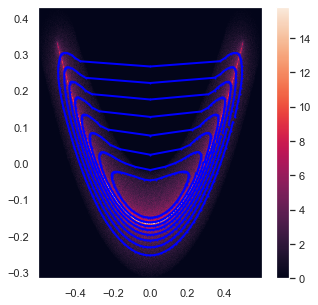

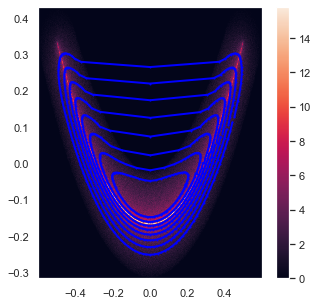

In [26]:
# for eps in np.array([0.5,0.1,0.05,0.01,0.005,0.001]):
for eps in np.array([0.002,0.003]):
    print('epsilon = '+str(eps))
    gamma = eps

    # Choice of the number of epochs / number of iterations
    epoch = 1
    n = Y.shape[0]
    n_iter = n*epoch
        
    # Compute the regularized maps by RM-FTT
    res_RM_fft = Robbins_Monro_Algo_fft2(grid_x, Y, eps=eps, gamma = gamma, c = 3/4, alpha = 0, epoch = epoch)
    hat_u = res_RM_fft[0]
    hat_W = res_RM_fft[1]

    # Gradient of u by finite differences in polar coordinates
    diff_hat_u = np.gradient(hat_u)
    diff_grad_hat_u = np.array([diff_hat_u[0]*p1,-diff_hat_u[1]*p2/(2*np.pi)])

    # change of variable from polar coordinates towards cartesian coordinates
    A1 = np.array([np.cos(grid_theta),(1/grid_r)*np.sin(grid_theta)])
    A2 = np.array([np.sin(grid_theta),(-1/grid_r)*np.cos(grid_theta)])

    rot_diff_grad_hat_u1 = diff_grad_hat_u[0]*A1[0]+diff_grad_hat_u[1]*A1[1]
    rot_diff_grad_hat_u2 = diff_grad_hat_u[0]*A2[0]+diff_grad_hat_u[1]*A2[1]
    rot_diff_grad_hat_u = np.array([rot_diff_grad_hat_u1,rot_diff_grad_hat_u2])

    # Optimal transport mapping with cartesian coordinates
    hat_T1 = grid_x[0] - rot_diff_grad_hat_u[0]
    hat_T2 = grid_x[1] - rot_diff_grad_hat_u[1]
    hat_T = np.array([hat_T1,hat_T2])

    # Visualisation of a quantile contour
    plt.figure(figsize=(5,5))
    # plt.scatter(Y.T[0],Y.T[1],color="black",s=1)

    # Visualisation de la densité par heatmap
    h = plt.hist2d(Y.T[0], Y.T[1],bins=500,density=True)
    plt.colorbar(h[3])

    for k in np.arange(1,9):
        plt.plot(hat_T1[k,:].reshape(p2,1),hat_T2[k,:].reshape(p2,1),color="blue",linewidth=2)
        plt.scatter(hat_T1[k,:].reshape(p2,1),hat_T2[k,:].reshape(p2,1),color="blue",s=1)

    plt.savefig('Figures/fig2_quantiles_p1_'+str(int(p1))+'_p2_'+str(int(p2))+'_epsilon_'+str(eps)+'_J_'+str(int(J))+'.png',bbox_inches='tight')